In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from plotting_utils import plotting_one_step_swsg
from swsg_ot_algorithm import SWSGDynamcis
import matplotlib as mpl
from scipy import optimize
import numpy as np
import matplotlib.pyplot as plt
import torch
import matplotlib.animation as animation
import pickle
from time import perf_counter_ns
from geomloss import SamplesLoss
from tqdm import tqdm

# My python classes for loops we've defined so far
from swsg_ot_algorithm import SWSGDynamcis
from unbalancedsinkhorn import UnbalancedOT, DebiasedUOT


In [17]:
for i in range(8):
    epsilon = (1/25) * np.sqrt(2)**(-i)
    N = 1/ epsilon**2
    n = int(np.sqrt(N))
    dt = (1/25) * np.sqrt(2)**(-7)
    print(epsilon, N, n, n**2)

0.04 625.0 25 625
0.028284271247461898 1250.0000000000002 35 1225
0.019999999999999997 2500.000000000001 50 2500
0.014142135623730947 5000.000000000003 70 4900
0.009999999999999998 10000.000000000004 100 10000
0.007071067811865473 20000.000000000015 141 19881
0.0049999999999999975 40000.000000000044 200 40000
0.0035355339059327364 80000.00000000006 282 79524


In [3]:
! pwd

/data/jjf817/SWSG_repo/dynamic_jet_study


In [2]:
! gpustat

nvidia6                     Mon Mar 24 17:25:07 2025  550.90.07
[0] NVIDIA GeForce RTX 3090 | 54°C, 100 % |  6132 / 24576 MB | zo122(6126M)
[1] NVIDIA GeForce RTX 3090 | 55°C,  99 % |  5115 / 24576 MB | mt622(798M) mt622(1406M) zo122(1448M) zo122(1448M)
[2] NVIDIA GeForce RTX 3090 | 54°C, 100 % | 17594 / 24576 MB | jz6422(17588M)
[3] NVIDIA GeForce RTX 3090 | 54°C, 100 % | 19888 / 24576 MB | tw1320(838M) jz6422(17588M) zo122(1448M)
[4] NVIDIA GeForce RTX 3090 | 50°C, 100 % | 23169 / 24576 MB | zo122(1456M) jz6422(21704M)
[5] NVIDIA GeForce RTX 3090 | 51°C, 100 % | 17714 / 24576 MB | jz6422(17708M)
[6] NVIDIA GeForce RTX 3090 | 52°C,  71 % | 15040 / 24576 MB | zo122(15034M)
[7] NVIDIA GeForce RTX 3090 | 50°C,  99 % |  2905 / 24576 MB | zo122(1448M) zo122(1448M)


In [20]:
# parser.add_argument("method", type=str, help="method; one of 'euler' 'heun' 'rk4'")

cuda = 4
strength = 0.0001

In [21]:
def normal_pdf(x, y, mu_x, mu_y, sigma,alpha):
    """
    Calculate the PDF of a bivariate normal distribution.
    """
    # Constants
    sigma2 = torch.tensor([sigma**2])
    mu_x_ = torch.tensor([mu_x])
    mu_y_ = torch.tensor([mu_y])
    
    norm_factor = 1 / (2 * torch.pi * sigma2) #_x * sigma_y * torch.sqrt(1 - rho ** 2))   
    # Z computation
    z_x = (x - mu_x_) 
    z_y = (y - mu_y_) 
    
    z = z_x**2  + z_y ** 2 
    
    # PDF computation
    pdf = alpha*norm_factor * torch.exp(-0.5 * z/sigma2)
    pdfg0 = -alpha* z_x/sigma2 *norm_factor * torch.exp(-0.5 * z/sigma2)
    pdfg1 = -alpha* z_y/sigma2 *norm_factor * torch.exp(-0.5 * z/sigma2)
    
    return pdf.unsqueeze(-1), pdfg0  , pdfg1

def jet_profile_initialisation(epsilon, strength, f=1.0, g=0.1, a=0.1, b=10.0, c=0.5, d=1.0, pykeop=True):
    """
    Initialise a jet profile and associated object for solving the sWSG problem.
    """
    # Decide on parameters
    global n1, n2, m1, m2
    n1, n2 = int(1 / epsilon), int(1 / epsilon)
    m1, m2 = int(1 / epsilon), int(1 / epsilon)

    # Assigning uniform weighting to points - Lloyde type
    def height_func(x):
        return a * np.tanh(b * (x - c)) + d

    # integral of tanh is ln(cosh) so;
    def int_h(x):
        return a * np.log(np.cosh(b * (x - 0.5)) / np.cosh(-b * 0.5)) / b + d*x

    X_j = torch.linspace(1 / (2 * n1), 1 - 1 / (2 * n1), n1)

    # Calculate nabla P: x + f^2 * g * partial h
    G_i = X_j + f**-2 * g * a * b * (1 - np.tanh(b * (X_j - 0.5)) ** 2)

    # Tile the 1D into a 2D profile
    X = torch.cartesian_prod(
        torch.linspace(1 / (2 * m2), 1 - 1 / (2 * m2), m2),
        torch.linspace(1 / (2 * m1), 1 - 1 / (2 * m1), m1),
    )
    Y = torch.cartesian_prod(
        torch.linspace(1 / (2 * n2), 1 - 1 / (2 * n2), n2), torch.Tensor(X_j)
    )
    G = torch.cartesian_prod(
        torch.linspace(1 / (2 * n2), 1 - 1 / (2 * n2), n2), torch.Tensor(G_i)
    )

    h_true = height_func(X[:, 1]).view(-1, 1)
    mu = torch.ones_like(h_true) * d  / len(X[:, 1])

    no, no0 , no1  = normal_pdf(X[:,0],X[:,1],0.5,0.3,0.1,strength)  ## 0 is stationnary 
    h_true = h_true  + no 
    h_true = h_true.div(torch.sum(h_true)) 
    G = G + torch.stack((no0, no1), dim=1)

    return X, Y, G, h_true, mu

In [22]:
def Sinkhorn_Divergence_balanced(
    X,
    α,
    Y,
    β,
    dense_symmetric_potential=None,
    f0=None,
    g0=None,
    force_type="pykeops",
    tol=1e-9,
    epsilon=0.01,
    fullcompute=False
):
    """
    # Run OT(a, b) on grid X, Y reusing the dense symmeric potential and cost
    # dense_symmetric_potential = dict(f=g, uot(dense, dense))
    # a,X has to be dense
    """
    cuda = α.device
    uotclass = DebiasedUOT(pykeops=True, cuda_device=cuda)
    uotclass.parameters(epsilon=epsilon)
    uotclass.densities(X, Y, α, β)

    tic = perf_counter_ns()
    if dense_symmetric_potential is None and not fullcompute:

        f_update, g_update, i_sup = uotclass.sinkhorn_algorithm(
            tol=tol,
            verbose=False,
            aprox="balanced",
            convergence_repeats=3,
            convergence_or_fail=True,
        )

        d = uotclass.dual_cost(force_type=force_type)

        print("DENSE symmetric update final convergence:", f_update, g_update, i_sup)
        return dict(f=uotclass.g.view(-1, 1).cpu(), dual=sum(d))
    elif fullcompute:
        try:
            f_update, g_update, i_sup = uotclass.sinkhorn_algorithm(
                f0=f0, g0=g0, aprox="balanced", tol=tol, convergence_or_fail=True
            )
        except RuntimeWarning:
            f_update, g_update, i_sup = uotclass.sinkhorn_algorithm(
                f0=f0, g0=g0, aprox="balanced", tol=tol, convergence_or_fail=False, epsilon_annealing=True,
            )
        print("Sinkhorn full compute final convergence:", f_update, g_update, i_sup)
        s = uotclass.sinkhorn_divergence(tol=tol, force_type='pykeops', return_type='dual')
        return s.cpu().item(), uotclass
    else:


        f_update, g_update, i_sup = uotclass.sinkhorn_algorithm(
            f0=f0, g0=g0, aprox="balanced", tol=tol, convergence_or_fail=False,
        )

        print("Sinkhorn update final convergence:", f_update, g_update, i_sup)

        # solve the new symmetric potential problem
        uotclass.debias_g = UnbalancedOT(
            pykeops=uotclass.pykeops,
            debias=False,
            cuda_device=uotclass.device,
        )

        uotclass.debias_g.parameters(
            uotclass.epsilon, uotclass.rho, uotclass.cost_const
        )

        uotclass.debias_g.densities(
            uotclass.Y_t, uotclass.Y_t, uotclass.β_t, uotclass.β_t
        )
        
        # solve the new symmetric potential problem
        uotclass.debias_f = UnbalancedOT(
            pykeops=uotclass.pykeops,
            debias=False,
            cuda_device=uotclass.device,
        )

        uotclass.debias_f.parameters(
            uotclass.epsilon, uotclass.rho, uotclass.cost_const
        )

        uotclass.debias_f.densities(
            uotclass.X_s, uotclass.X_s, uotclass.α_s, uotclass.α_s
        )
        
        # load in known potential
        uotclass.debias_f.f = dense_symmetric_potential['f'].to(uotclass.α_s)
        uotclass.debias_f.g = dense_symmetric_potential['f'].to(uotclass.α_s)

        f_update, g_update, i_sup = uotclass.debias_g.sinkhorn_algorithm(
            tol=tol,
            verbose=False,
            left_divergence=uotclass.right_div.print_type(),
            right_divergence=uotclass.right_div.print_type(),
            convergence_repeats=3,
        )
        print("GGG update final convergence:", f_update, g_update, i_sup)

        f_update, g_update, i_sup = uotclass.debias_f.sinkhorn_algorithm(
            tol=tol,
            verbose=False,
            left_divergence=uotclass.right_div.print_type(),
            right_divergence=uotclass.right_div.print_type(),
            convergence_repeats=1,
        )
        toc = perf_counter_ns()

        print("FFFF update final convergence:", f_update, g_update, i_sup)
        print(f"W2 Computed in {toc-tic} ns")

        return (
            sum(uotclass.dual_cost(force_type=force_type))
            - (
                sum(uotclass.debias_f.dual_cost(force_type=force_type))
                + sum(uotclass.debias_g.dual_cost(force_type=force_type))
            )
            / 2
            + uotclass.epsilon * (uotclass.α_s.sum() - uotclass.β_t.sum()) ** 2 / 2
        ).cpu().item(), uotclass

In [23]:
global device
device = f'cuda:{cuda}'

In [29]:
data_fine[0].shape

torch.Size([79524, 2, 1414])

In [25]:
# Load in fine data
i=7
epsilon = (1/25) * np.sqrt(2)**(-i)
N = 1/ epsilon**2
n = int(np.sqrt(N))
dt = (1/25) * np.sqrt(2)**(-7)
method = 'heun'

with open(f'data_store/simstudy_shorter_{method}_{epsilon}_{epsilon}_strength_{strength}.pkl', 'rb') as f:
    data_fine = pickle.load(f)
    
X_dense, _, _, sigma_weights_dense, _ = jet_profile_initialisation(epsilon, strength, f=1.0, g=0.1, a=0.1, b=10.0, c=0.5, d=1.0)
sigma_weights_dense /= sigma_weights_dense.sum()

In [30]:
time = 1414 -1
try:
    with open(f'data_store/simstudy_shorter_{method}_{epsilon}_{epsilon}_strength_{strength}_dense_potential_T5.pkl', 'rb') as f:
        d = pickle.load(f)
except FileNotFoundError:
    # Compute and save the symmtric potential;
    d = Sinkhorn_Divergence_balanced(
        data_fine[0][:,:,time].to(device),
        sigma_weights_dense.to(device),
        data_fine[0][:,:,time].to(device),
        sigma_weights_dense.to(device),
        dense_symmetric_potential=None,
        f0=None,
        g0=None,
        force_type="pykeops",
        tol=1e-7,
        epsilon=0.01,
        fullcompute=False
    )

    print(d)

    with open(f'data_store/simstudy_shorter_{method}_{epsilon}_{epsilon}_strength_{strength}_dense_potential_T5.pkl', 'wb') as f:
        pickle.dump(d,f)

Convergence in f, g updates below 1e-07 in 89 iterations
DENSE symmetric update final convergence: tensor(9.227119323468314e-08, device='cuda:4', dtype=torch.float64) tensor(8.860028295927524e-08, device='cuda:4', dtype=torch.float64) 89
{'f': tensor([[0.009559094634425],
        [0.009314491105538],
        [0.009078093487810],
        ...,
        [0.008111692356941],
        [0.008350450354869],
        [0.008597290436045]], dtype=torch.float64), 'dual': tensor(0.029262094999814, device='cuda:4', dtype=torch.float64)}


In [ ]:
s = []
time = 1414 -1

for i in range(7):
    epsilon = (1/25) * np.sqrt(2)**(-i)
    N = 1/ epsilon**2
    n = int(np.sqrt(N))
    dt = (1/25) * np.sqrt(2)**(-7)
    print(epsilon, N, n, n**2)
    
        # Load in course data
    with open(f'data_store/simstudy_shorter_{method}_{dt}_{epsilon}_strength_{strength}.pkl', 'rb') as f:
        data_course = pickle.load(f)
        
    _, _, _, sigma_weights, _ = jet_profile_initialisation(epsilon, strength, f=1.0, g=0.1, a=0.1, b=10.0, c=0.5, d=1.0)

    sigma_weights /= sigma_weights.sum()
    
    tic = perf_counter_ns()
    output, uotclass = Sinkhorn_Divergence_balanced(
            data_fine[0][:,:,time].to(device),
            sigma_weights_dense.to(device),
            data_course[0][:, :, time].to(device),
            sigma_weights.to(device),
            dense_symmetric_potential=d,
            force_type="pykeops",
            tol=1e-10,
            epsilon=0.01,
            fullcompute=False
        )  
    toc = perf_counter_ns()

    print('TIMING: ', tic-toc, output)
    s.append(output)
    
    with open('saving_sigmashorter_T5.pkl', 'wb') as f:
        pickle.dump(s, f)

0.04 625.0 25 625
Convergence in f, g updates below 1e-10 in 173 iterations
Sinkhorn update final convergence: tensor(9.906785808366791e-11, device='cuda:4', dtype=torch.float64) tensor(9.615350269470690e-11, device='cuda:4', dtype=torch.float64) 173
Convergence in f, g updates below 1e-10 in 174 iterations
GGG update final convergence: tensor(9.368582298829864e-11, device='cuda:4', dtype=torch.float64) tensor(8.996819261808398e-11, device='cuda:4', dtype=torch.float64) 174
Convergence in f, g updates below 1e-10 in 84 iterations
FFFF update final convergence: tensor(9.294933572823183e-11, device='cuda:4', dtype=torch.float64) tensor(8.925269377735301e-11, device='cuda:4', dtype=torch.float64) 84
W2 Computed in 377865816087 ns
TIMING:  -380057418478 4.591846170944097e-06
0.028284271247461898 1250.0000000000002 35 1225
Convergence in f, g updates below 1e-10 in 182 iterations
Sinkhorn update final convergence: tensor(9.769251380076227e-11, device='cuda:4', dtype=torch.float64) tensor(9.

/data/jjf817/PhD_code/flipflop/flipflop/flipflop.py:39: UserWarning: Convergence has completely plateaued
  warnings.warn(


Sinkhorn update final convergence: tensor(3.576224177903597e-10, device='cuda:4', dtype=torch.float64) tensor(3.576224161098464e-10, device='cuda:4', dtype=torch.float64) 373
Convergence in f, g updates below 1e-10 in 174 iterations
GGG update final convergence: tensor(9.379563098432797e-11, device='cuda:4', dtype=torch.float64) tensor(9.006597204153088e-11, device='cuda:4', dtype=torch.float64) 174
Convergence in f, g updates below 1e-10 in 84 iterations
FFFF update final convergence: tensor(9.294933572823183e-11, device='cuda:4', dtype=torch.float64) tensor(8.925269377735301e-11, device='cuda:4', dtype=torch.float64) 84
W2 Computed in 486266032301 ns
TIMING:  -488476013440 3.6633869499328987e-07
0.009999999999999998 10000.000000000004 100 10000
Sinkhorn update final convergence: tensor(8.838196841054469e-10, device='cuda:4', dtype=torch.float64) tensor(8.838196797686382e-10, device='cuda:4', dtype=torch.float64) 366
Convergence in f, g updates below 1e-10 in 174 iterations
GGG update

In [12]:

# Given data
with open('saving_sigmashorter_T5.pkl', 'rb') as f:
#         pickle.dump(s, f)
    s = pickle.load(f)
    
epsilons = [(1/25) * np.sqrt(2)**(-i) for i in range(7)]
s_values = np.array(s)  # Assuming 's' is defined elsewhere
filtered_s = np.where(s_values > 1e-14, s_values, 0)  # Replace values below threshold with 0
sqrt_s = np.sqrt(filtered_s)

# Log-log plot
plt.figure(figsize=(7, 5))
plt.loglog(epsilons, sqrt_s, 'o:', label='Data points', markersize=8)

# Polyfit for all data
coeffs_all = np.polyfit(np.log(epsilons), np.log(sqrt_s), 1)
fit_all = np.exp(coeffs_all[1]) * epsilons**coeffs_all[0]
plt.loglog(epsilons, fit_all, '--', label=f'Fit (all data): slope={coeffs_all[0]:.2f}')

# # Polyfit for central points (excluding first and last)
# central_eps = epsilons[2:]
# central_sqrt_s = sqrt_s[2:]
# coeffs_central = np.polyfit(np.log(central_eps), np.log(central_sqrt_s), 1)
# fit_central = np.exp(coeffs_central[1]) * central_eps**coeffs_central[0]
# plt.loglog(central_eps, fit_central, '-.', label=f'Fit (central points): slope={coeffs_central[0]:.2f}')

plt.xticks(epsilons, [f"{eps:.6f}" for eps in epsilons])

# Labels and formatting
plt.title('Perturbed Jet comaprison against higher resolution sigma, at T=0')
plt.xlabel(r'$\varepsilon$ = 1/$\sqrt{N}$', fontsize=14)
plt.ylabel(r'$\sqrt{S_{0.01}}$', fontsize=14)
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.6)
plt.show()


EOFError: Ran out of input

# Height

In [23]:
# Load in fine data
i=7
epsilon = (1/25) * np.sqrt(2)**(-i)
N = 1/ epsilon**2
n = int(np.sqrt(N))
dt = (1/25) * np.sqrt(2)**(-7)
method = 'heun'

with open(f'data_store/simstudy_shorter_{method}_{epsilon}_{epsilon}_strength_{strength}.pkl', 'rb') as f:
    data_fine = pickle.load(f)
    
X_dense, _, _, sigma_weights_dense, _ = jet_profile_initialisation(epsilon, strength, f=1.0, g=0.1, a=0.1, b=10.0, c=0.5, d=1.0)
sigma_weights_dense /= sigma_weights_dense.sum()

In [24]:
try:
    with open(f'data_store/simstudy_shorter_{method}_{epsilon}_{epsilon}_strength_{strength}_dense_potential_height.pkl', 'rb') as f:
        d = pickle.load(f)
except FileNotFoundError:
    # Compute and save the symmtric potential;
    d = Sinkhorn_Divergence_balanced(
        X_dense.to(device),
        data_fine[1][:,:,-1].to(device),
        X_dense.to(device),
        data_fine[1][:,:,-1].to(device),
        dense_symmetric_potential=None,
        f0=None,
        g0=None,
        force_type="pykeops",
        tol=1e-9,
        epsilon=0.01,
        fullcompute=False
    )

    print(d)

    with open(f'data_store/simstudy_shorter_{method}_{epsilon}_{epsilon}_strength_{strength}_dense_potential_height.pkl', 'wb') as f:
        pickle.dump(d,f)

In [38]:
for i in range(7):
    epsilon = (1/25) * np.sqrt(2)**(-i)
    N = 1/ epsilon**2
    n = int(np.sqrt(N))
    dt = (1/25) * np.sqrt(2)**(-7)
    print('eps, N, sqrt(N): ', epsilon,  int(N), n)
i=7
epsilon = (1/25) * np.sqrt(2)**(-i)
N = 1/ epsilon**2
n = int(np.sqrt(N))
print('FINEST: eps, N, sqrt(N): ', epsilon, int(N), n)

    

eps, N, sqrt(N):  0.04 625 25
eps, N, sqrt(N):  0.028284271247461898 1250 35
eps, N, sqrt(N):  0.019999999999999997 2500 50
eps, N, sqrt(N):  0.014142135623730947 5000 70
eps, N, sqrt(N):  0.009999999999999998 10000 100
eps, N, sqrt(N):  0.007071067811865473 20000 141
eps, N, sqrt(N):  0.0049999999999999975 40000 200
FINEST: eps, N, sqrt(N):  0.0035355339059327364 80000 282


In [32]:
s1 = []

for i in range(7):
    epsilon = (1/25) * np.sqrt(2)**(-i)
    N = 1/ epsilon**2
    n = int(np.sqrt(N))
    dt = (1/25) * np.sqrt(2)**(-7)
    print(epsilon, N, n, n**2)
    
    # Load in course data
    with open(f'data_store/simstudy_shorter_{method}_{dt}_{epsilon}_strength_{strength}.pkl', 'rb') as f:
        data_course = pickle.load(f)

    X, _, _, sigma_weights, _ = jet_profile_initialisation(epsilon, strength, f=1.0, g=0.1, a=0.1, b=10.0, c=0.5, d=1.0)

    sigma_weights /= sigma_weights.sum()
    
    tic = perf_counter_ns()
    output, uotclass = Sinkhorn_Divergence_balanced(
            X_dense.to(device),
            (data_fine[1][:,:,-1]/data_fine[1][:,:,-1].sum()).to(device).view(-1,1),
            X,
            (data_course[1][:, :, -1]/data_course[1][:, :, -1].sum()).to(device).view(-1,1),
            dense_symmetric_potential=d,
            force_type="pykeops",
            tol=1e-10,
            epsilon=0.01,
            fullcompute=False
        )  
    toc = perf_counter_ns()
    
    s1.append(output)
    with open('shorter_heights.pkl', 'wb') as f:
        pickle.dump(s1, f)
#  Look at solutions

0.04 625.0 25 625
Convergence in f, g updates below 1e-10 in 138 iterations
Sinkhorn update final convergence: tensor(9.712639026382419e-11, device='cuda:0', dtype=torch.float64) tensor(9.178529897929666e-11, device='cuda:0', dtype=torch.float64) 138
Convergence in f, g updates below 1e-10 in 134 iterations
GGG update final convergence: tensor(9.995582833655092e-11, device='cuda:0', dtype=torch.float64) tensor(9.510425346553886e-11, device='cuda:0', dtype=torch.float64) 134
Convergence in f, g updates below 1e-10 in 22 iterations
FFFF update final convergence: tensor(9.374453296961960e-11, device='cuda:0', dtype=torch.float64) tensor(8.919515820382529e-11, device='cuda:0', dtype=torch.float64) 22
W2 Computed in 105303457202 ns
0.028284271247461898 1250.0000000000002 35 1225
Convergence in f, g updates below 1e-10 in 136 iterations
Sinkhorn update final convergence: tensor(9.551856527956204e-11, device='cuda:0', dtype=torch.float64) tensor(9.046405378271283e-11, device='cuda:0', dtype=t

In [48]:
s1

[6.760994302086598e-07,
 2.2646722625668803e-07,
 8.631257368552081e-08,
 3.4145009531610926e-08,
 1.1947494979458462e-08,
 3.2887529158309725e-09,
 5.116865750554034e-10]

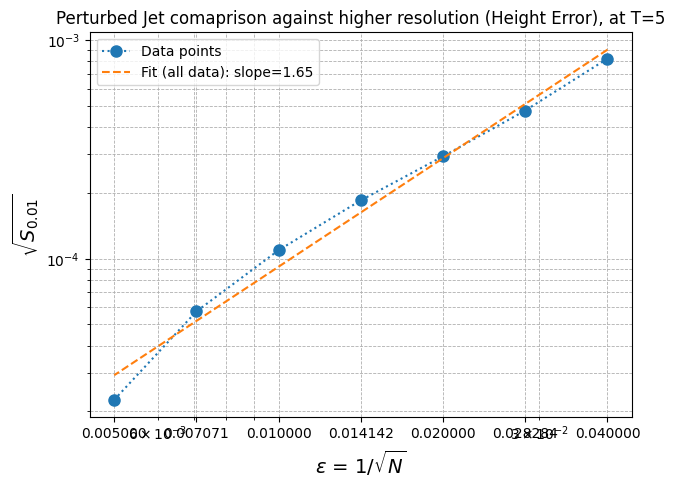

In [49]:

s  = s1
epsilons = [(1/25) * np.sqrt(2)**(-i) for i in range(7)]
s_values = np.array(s)  # Assuming 's' is defined elsewhere
filtered_s = np.where(s_values > 1e-14, s_values, 0)  # Replace values below threshold with 0
sqrt_s = np.sqrt(filtered_s)

# Log-log plot
plt.figure(figsize=(7, 5))
plt.loglog(epsilons, sqrt_s, 'o:', label='Data points', markersize=8)

# Polyfit for all data
coeffs_all = np.polyfit(np.log(epsilons), np.log(sqrt_s), 1)
fit_all = np.exp(coeffs_all[1]) * epsilons**coeffs_all[0]
plt.loglog(epsilons, fit_all, '--', label=f'Fit (all data): slope={coeffs_all[0]:.2f}')

# # Polyfit for central points (excluding first and last)
# central_eps = epsilons[2:]
# central_sqrt_s = sqrt_s[2:]
# coeffs_central = np.polyfit(np.log(central_eps), np.log(central_sqrt_s), 1)
# fit_central = np.exp(coeffs_central[1]) * central_eps**coeffs_central[0]
# plt.loglog(central_eps, fit_central, '-.', label=f'Fit (central points): slope={coeffs_central[0]:.2f}')

plt.xticks(epsilons, [f"{eps:.6f}" for eps in epsilons])

# Labels and formatting
plt.title('Perturbed Jet comaprison against higher resolution (Height Error), at T=5')
plt.xlabel(r'$\varepsilon$ = 1/$\sqrt{N}$', fontsize=14)
plt.ylabel(r'$\sqrt{S_{0.01}}$', fontsize=14)
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.6)
plt.show()


# Plotting

0.0035355339059327364 80000.00000000006 282 79524


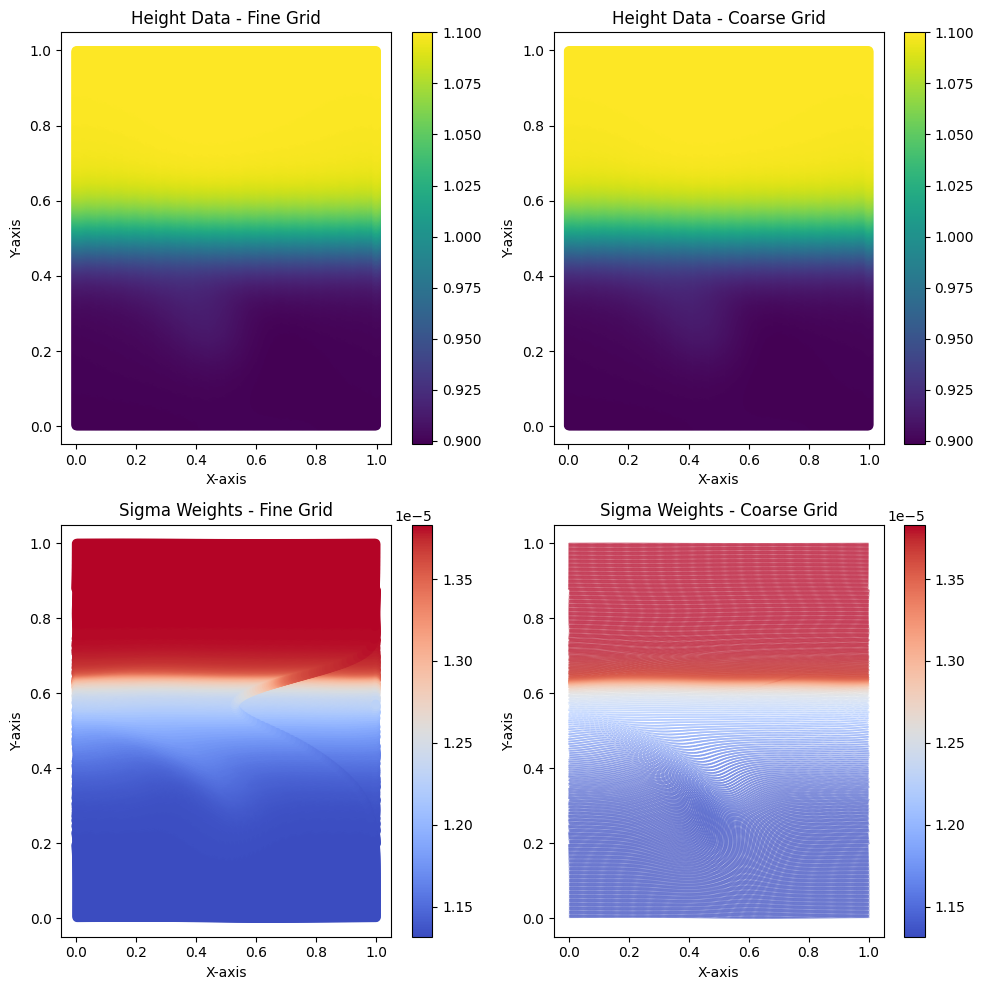

In [12]:
import numpy as np
import matplotlib.pyplot as plt
shift = 0


i = 7
epsilon = (1/25) * np.sqrt(2)**(-i)
N = 1/ epsilon**2
n = int(np.sqrt(N))
dt = (1/25) * np.sqrt(2)**(-7)
print(epsilon, N, n, n**2)

# Load in course data
with open(f'data_store/simstudy_shorter_{method}_{dt}_{epsilon}_strength_{strength}.pkl', 'rb') as f:
    data_course = pickle.load(f)

X, _, _, sigma_weights, _ = jet_profile_initialisation(epsilon, strength, f=1.0, g=0.1, a=0.1, b=10.0, c=0.5, d=1.0)


fig, axes = plt.subplots(2, 2, figsize=(10, 10))  # 2x2 grid

# First scatter plot
sc = axes[0, 0].scatter(X_dense[:, 0], X_dense[:, 1], c=data_fine[1][:, :, -1-shift], cmap='viridis')
axes[0, 0].set_title('Height Data - Fine Grid')
fig.colorbar(sc, ax=axes[0, 0])

# Second scatter plot
sc = axes[0, 1].scatter(X[:, 0], X[:, 1], c=data_course[1][:, :, -1-shift], cmap='viridis')
axes[0, 1].set_title('Height Data - Coarse Grid')
fig.colorbar(sc, ax=axes[0, 1])

# Third scatter plot
sc = axes[1, 0].scatter(data_fine[0][:, 0, -1-shift], data_fine[0][:, 1, -1-shift], c=sigma_weights_dense, cmap='coolwarm')
axes[1, 0].set_title('Sigma Weights - Fine Grid')
fig.colorbar(sc, ax=axes[1, 0])

# Fourth scatter plot
sc = axes[1, 1].scatter(data_course[0][:, 0, -1-shift], data_course[0][:, 1, -1-shift], c=sigma_weights, cmap='coolwarm', s=0.05125)
axes[1, 1].set_title('Sigma Weights - Coarse Grid')
fig.colorbar(sc, ax=axes[1, 1])

# Formatting
for ax in axes.flat:
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')

plt.tight_layout()
plt.show()


0.0035355339059327364 80000.00000000006 282 79524


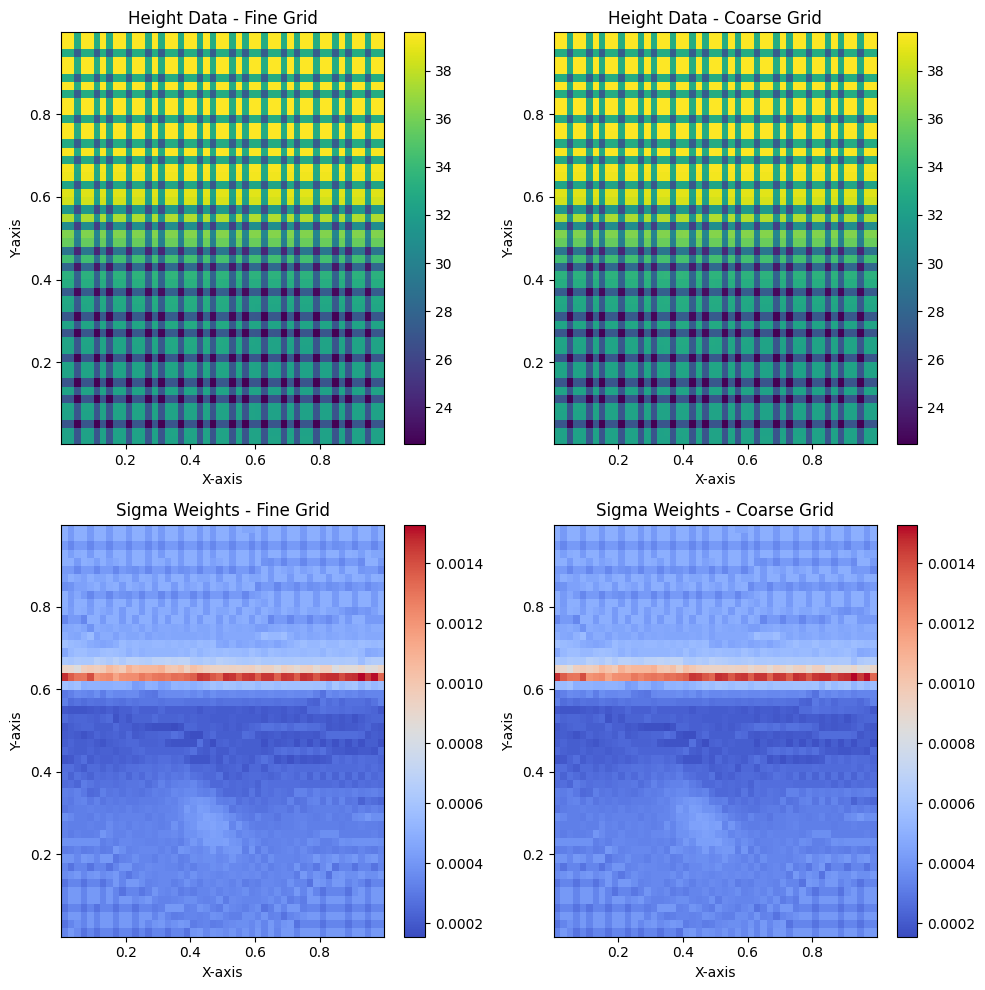

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

shift = 0

i = 7
epsilon = (1/25) * np.sqrt(2)**(-i)
N = 1/ epsilon**2
n = int(np.sqrt(N))
dt = (1/25) * np.sqrt(2)**(-7)
print(epsilon, N, n, n**2)

# Load in course data
with open(f'data_store/simstudy_shorter_{method}_{dt}_{epsilon}_strength_{strength}.pkl', 'rb') as f:
    data_course = pickle.load(f)

X, _, _, sigma_weights, _ = jet_profile_initialisation(epsilon, strength, f=1.0, g=0.1, a=0.1, b=10.0, c=0.5, d=1.0)

fig, axes = plt.subplots(2, 2, figsize=(10, 10))  # 2x2 grid

# First 2D histogram
hb = axes[0, 0].hist2d(X_dense[:, 0], X_dense[:, 1], weights=data_fine[1][:, :, -1-shift].flatten(), bins=50, cmap='viridis')
axes[0, 0].set_title('Height Data - Fine Grid')
fig.colorbar(hb[3], ax=axes[0, 0])

# Second 2D histogram
hb = axes[0, 1].hist2d(X[:, 0], X[:, 1], weights=data_course[1][:, :, -1-shift].flatten(), bins=50, cmap='viridis')
axes[0, 1].set_title('Height Data - Coarse Grid')
fig.colorbar(hb[3], ax=axes[0, 1])

# Third 2D histogram
hb = axes[1, 0].hist2d(data_fine[0][:, 0, -1-shift], data_fine[0][:, 1, -1-shift], weights=sigma_weights_dense.flatten(), bins=50, cmap='coolwarm')
axes[1, 0].set_title('Sigma Weights - Fine Grid')
fig.colorbar(hb[3], ax=axes[1, 0])

# Fourth 2D histogram
hb = axes[1, 1].hist2d(data_course[0][:, 0, -1-shift], data_course[0][:, 1, -1-shift], weights=sigma_weights.flatten(), bins=50, cmap='coolwarm')
axes[1, 1].set_title('Sigma Weights - Coarse Grid')
fig.colorbar(hb[3], ax=axes[1, 1])

# Formatting
for ax in axes.flat:
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')

plt.tight_layout()
plt.show()

In [ ]:
# Fourth scatter plo
shift = 1400
fig = plt.figure(figsize=(7,5))
sc = plt.scatter(data_course[0][:, 0, -1-shift], data_course[0][:, 1, -1-shift], c=sigma_weights, cmap='coolwarm', s=0.05125)
plt.title('Sigma Weights - Coarse Grid')
plt.colorbar(sc)

NameError: name 'data_course' is not defined

Error in callback <function _draw_all_if_interactive at 0x7f0dbfb067a0> (for post_execute):


NameError: name 'data_course' is not defined

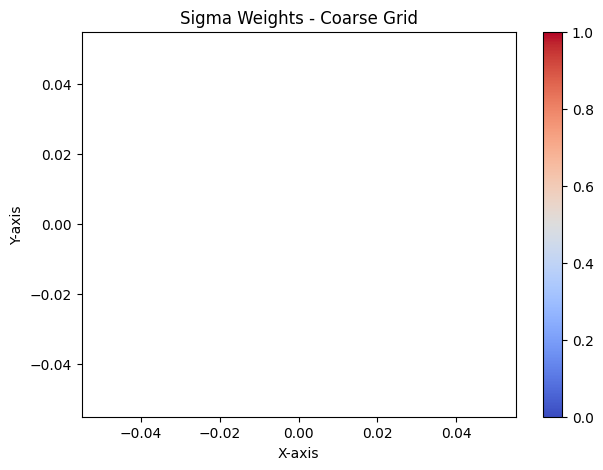

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from matplotlib.animation import FuncAnimation




# Animation parameters
shift_max = 1412  # Start shift
frames = shift_max  # Animate from 1413 down to 0
interval = 50  # Milliseconds between frames

# Create figure
fig, ax = plt.subplots(figsize=(7, 5))

# Initial scatter plot (empty, updated in animation)
sc = ax.scatter([], [], c=[], cmap='coolwarm', s=0.05125)

# Set title and colorbar
ax.set_title('Sigma Weights - Coarse Grid')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
cbar = plt.colorbar(sc, ax=ax)

# **Animation function**
def update(frame):
    shift = shift_max - frame  # Reduce shift from 1413 to 0
    x = data_course[0][:, 0, -1 - shift]
    y = data_course[0][:, 1, -1 - shift]

    sc.set_offsets(np.c_[x, y])  # Update x, y positions
    sc.set_array(sigma_weights.view(-1,))  # Update colors

    ax.set_title(f'Sigma Weights - Coarse Grid (shift={shift})')
    return sc,

# Create animation
ani = FuncAnimation(fig, update, frames=frames, interval=interval, blit=False)

# Show animation
# plt.show()

# Optional: Save animation
ani.save('sigma_weights_animation.mp4', fps=20, dpi=200)
# ani.save('sigma_weights_animation.gif', fps=20, dpi=200, writer='pillow')


In [ ]:
sigma_weights_dense.shape